
# **Regressão Logística com Redes Neurais Artificiais**

Neste exercício você construirá um *classificador de regressão logística* para reconhecer gatos. Esta tarefa o guiará como fazer isso com uma rede neural.

**Instruções:**

*   Não use loops (for/while) em seu código, a menos que as instruções explicitamente solicitem que você faça isso.


Você aprenderá a:


*   Construir uma arquitetura geral de um algoritmo de aprendizagem, incluindo: 
 *  Parâmetros de inicialização
 *  Calculando a função de custo e seu gradiente
 *  Usando um algoritmo de otimização (gradiente descendente)
*   Reunir todas as três funções acima em uma função de modelo principal, na ordem certa.









# **1 - Packages**

Primeiro, vamos executar a célula abaixo para importar todos os pacotes de que você precisará durante esta tarefa.

**numpy** é o pacote fundamental para a computação científica com Python.

**h5py** é um pacote comum para interagir com um conjunto de dados armazenado em um arquivo H5.

**matplotlib** é uma biblioteca famosa para traçar gráficos em Python.

**PIL** e **scipy** são usados aqui para testar seu modelo com sua própria imagem no final.

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage


%matplotlib inline

In [48]:
def load_dataset():
    train_dataset = h5py.File('train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

**Problema:** você recebe um conjunto de dados ("data.h5") contendo:

- um conjunto de treinamento de imagens m_train rotuladas como gato (y = 1) ou não gato (y = 0)
- um conjunto de teste de imagens m_test rotuladas como gato ou não gato
- cada imagem tem uma forma (num_px, num_px, 3) onde 3 é para os 3 canais (RGB). Assim, cada imagem é quadrada (altura = num_px) e (largura = num_px).

Você construirá um algoritmo de reconhecimento de imagem simples que pode classificar corretamente as imagens como gatos ou não.

Vamos nos familiarizar mais com o conjunto de dados. Carregue os dados executando o código a seguir.

In [49]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

Adicionamos "_orig" no final dos conjuntos de dados de imagem (treinar e testar) porque vamos pré-processá-los. Após o pré-processamento, terminaremos com train_set_x e test_set_x (os rótulos train_set_y e test_set_y não precisam de nenhum pré-processamento).

Cada linha de train_set_x_orig e test_set_x_orig é uma matriz que representa uma imagem. Você pode visualizar um exemplo executando o código a seguir. Sinta-se à vontade também para alterar o valor do índice e execute novamente para ver outras imagens.

y = [1], it's a 'cat' picture.


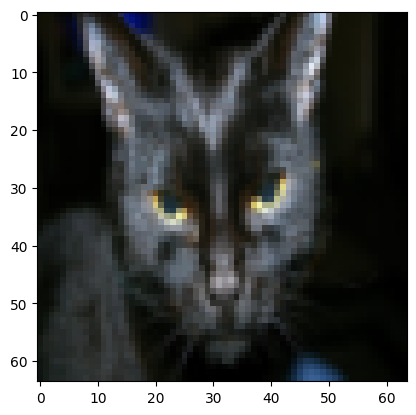

In [50]:
# Example of a picture
index = 25
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

Muitos erros de software no aprendizado profundo vêm de dimensões de matriz / vetor que não se encaixam. Se você puder manter suas dimensões de matriz / vetor retas, você percorrerá um longo caminho para eliminar muitos bugs.

**Exercício:** Encontre os valores para:

- m_train (número de exemplos de treinamento)
- m_test (número de exemplos de teste)
- num_px (= altura = largura de uma imagem de treinamento)

Lembre-se de que train_set_x_orig é uma matriz numpy de forma (m_train, num_px, num_px, 3). Por exemplo, você pode acessar m_train escrevendo train_set_x_orig.shape [0].

In [51]:
### START CODE HERE ### (≈ 3 lines of code)
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

### END CODE HERE ###

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


Saída esperada para m_train, m_test and num_px:

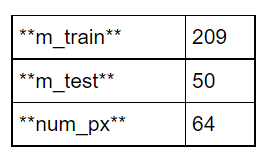

Por conveniência, agora você deve remodelar as imagens de forma (num_px, num_px, 3) em uma matriz numpy de forma (num_px ∗ num_px ∗ 3, 1). Depois disso, nosso conjunto de dados de treinamento (e teste) é uma matriz numpy em que cada coluna representa uma imagem flattened (achatada). Deve haver colunas m_train (respectivamente m_test).

**Exercício:** Remodele os conjuntos de dados de treinamento e teste para que as imagens de tamanho (num_px, num_px, 3) sejam achatadas em vetores únicos de forma (num_px ∗ num_px ∗ 3, 1).

Um truque quando você deseja nivelar uma matriz X de forma (a, b, c, d) em uma matriz X_flatten de forma (b ∗ c ∗ d, a) é usar:

X_flatten = X.reshape (X.shape [0], -1) .T # X.T é a transposta de X

In [52]:
# Reshape the training and test examples

### START CODE HERE ### (≈ 2 lines of code)

# Remodelar o conjunto de treinamento
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T

# Remodelar o conjunto de teste
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T


### END CODE HERE ###

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))


train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


Expected Output:

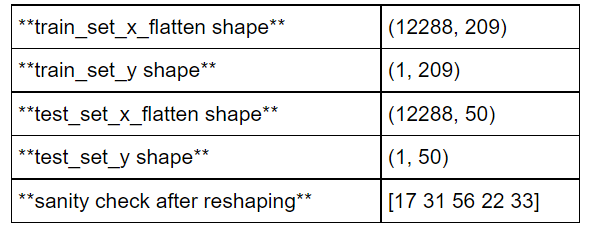

Para representar imagens coloridas, os canais vermelho, verde e azul (RGB) devem ser especificados para cada pixel e, portanto, o valor do pixel é na verdade um vetor de três números variando de 0 a 255.

Uma etapa comum de pré-processamento no aprendizado de máquina é centralizar e padronizar seu conjunto de dados, o que significa que você subtrai a média de toda a matriz numpy de cada exemplo e, em seguida, divide cada exemplo pelo desvio padrão de toda a matriz numpy. Mas para conjuntos de dados de imagem, é mais simples e mais conveniente e funciona quase tão bem apenas dividir cada linha do conjunto de dados por 255 (o valor máximo de um canal de pixel).

Vamos padronizar nosso conjunto de dados.

In [53]:
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

O que você precisa lembrar:

As etapas comuns para o pré-processamento de um novo conjunto de dados são:

* Descubra as dimensões e formas do problema (m_train, m_test, num_px, ...) 
* Remodele os conjuntos de dados de forma que cada exemplo seja agora um vetor de tamanho (num_px * num_px * 3, 1) 
* Padronize" os dados

# **3 - Arquitetura geral do algoritmo de aprendizagem**
É hora de projetar um algoritmo simples para distinguir imagens de gatos de imagens que não sejam de gatos.

Você vai construir uma regressão logística, usando uma rede neural. 

A figura a seguir explica porque a regressão logística é, na verdade, uma rede neural muito simples!

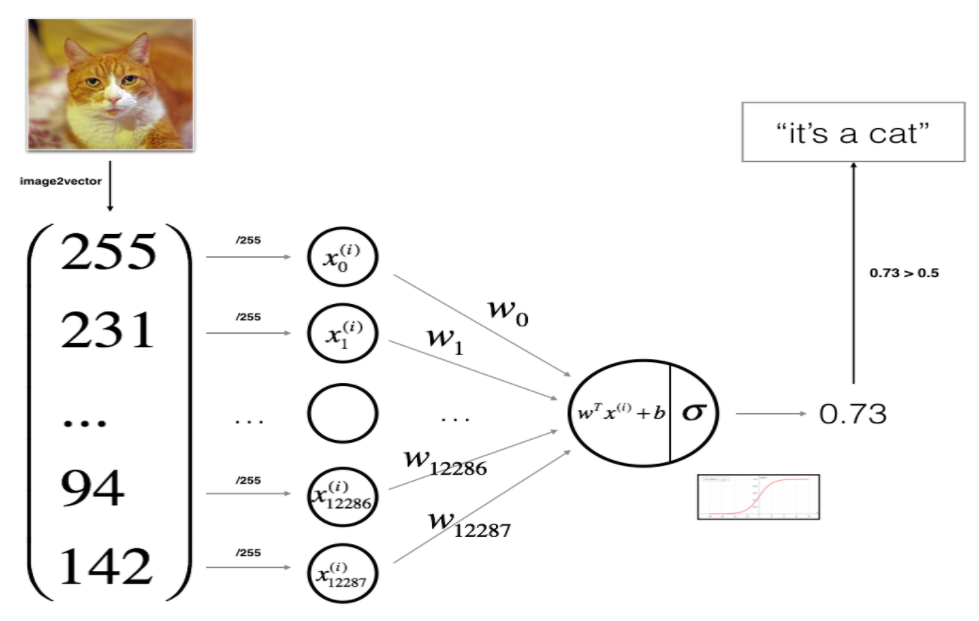

Expressão matemática do algoritmo:

Para um exemplo 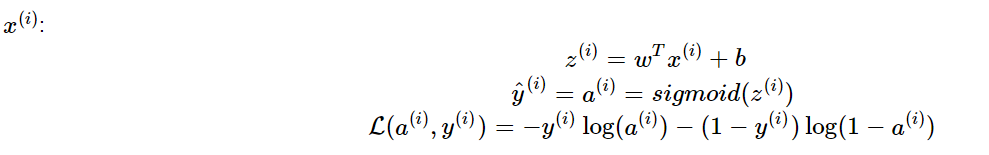

O custo é então calculado somando todos os exemplos de treinamento:

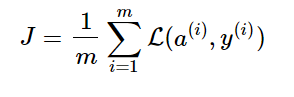

**Etapas principais:** neste exercício, você executará as seguintes etapas:

- Inicializar os parâmetros do modelo
- Aprender os parâmetros do modelo, minimizando o custo
- Usar os parâmetros aprendidos para fazer previsões (no conjunto de teste)
- Analisar os resultados e concluir

# **4 - Construindo as partes do algoritmo**
As principais etapas para a construção de uma rede neural são:

1. Definir a estrutura do modelo (como o número de recursos de entrada)
2. Inicializar os parâmetros do modelo
3. Loops:
 * Calcular a perda de corrente (propagação direta)
 * Calcular gradiente atual (propagação para trás)
 * Atualizar os parâmetros (gradiente descendente)

Freqüentemente, você constrói de 1 a 3 separadamente e os integra em uma função que chamamos de model().

# **4.1 - Funções auxiliares**
**Exercício:** Usando seu código de "Python Basics", implemente sigmoid(). 

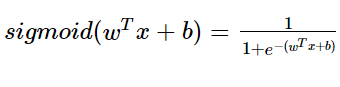

Como você viu na figura acima, você precisa calcular sigmóide (wTx + b) = 11 + e− (wTx + b) para fazer previsões. Use np.exp ().

In [54]:
# GRADED FUNCTION: sigmoid

def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    ### START CODE HERE ### (≈ 1 line of code)
    s = 1 / (1 + np.exp(-z))
    ### END CODE HERE ###
    
    return s

In [55]:
print ("sigmoid([0, 2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0, 2]) = [0.5        0.88079708]


Saída esperada

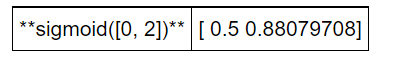

# **4.2 - Inicialização dos parâmetros**
**Exercício: **Implemente a inicialização dos parâmetros na célula abaixo. Você deve inicializar w como um vetor de zeros. Se você não sabe qual função numpy usar, procure np.zeros () na documentação da biblioteca Numpy.

In [56]:
# GRADED FUNCTION: initialize_with_zeros

def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    
    ### START CODE HERE ### (≈ 1 line of code)

    w = np.zeros((dim, 1))

    ### END CODE HERE ###

    b = 0

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [57]:
dim = 2
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0


Saída esperada:

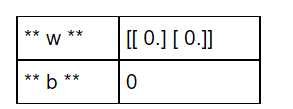

For image inputs, w will be of shape (num_px  ×  num_px  ×  3, 1)

# **4.3 - Propagação Forward e Backward**
Agora que seus parâmetros foram inicializados, você pode executar as etapas de propagação "para frente" e "para trás" para aprender os parâmetros.

Exercício: Implemente uma função propagate () que calcule a função de custo e seu gradiente.

Dicas:

Propagação para frente:

Você tem X


Compute 

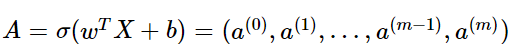

Calcule a função de custo

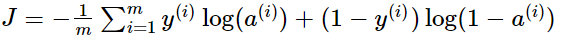

Aqui estão as funções que você usará

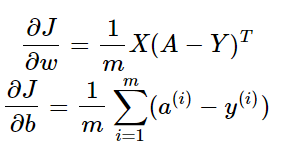

In [58]:
# GRADED FUNCTION: propagate

def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
    """
    m = X.shape[1]
 
    
    # FORWARD PROPAGATION (FROM X TO COST)
    ### START CODE HERE ### (≈ 2 lines of code)

    z = np.dot(w.T,X) + b
    A = sigmoid(z)                          # compute activation
    cost = (-1/m)*np.sum(Y*np.log(A) + (1-Y)*np.log(1-A))      # compute cost

    ### END CODE HERE ###
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    ### START CODE HERE ### (≈ 2 lines of code)

    dw = (1/m)*np.dot(X,(A-Y).T)
    db = (1/m)*np.sum(A-Y)

    ### END CODE HERE ###

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    #cost = np.squeeze(cost)
    #assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [59]:
w, b, X, Y = np.array([[1],[2]]), 2, np.array([[1,2],[3,4]]), np.array([[1,0]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99993216]
 [1.99980262]]
db = 0.49993523062470574
cost = 6.000064773192205


Saída esperada:

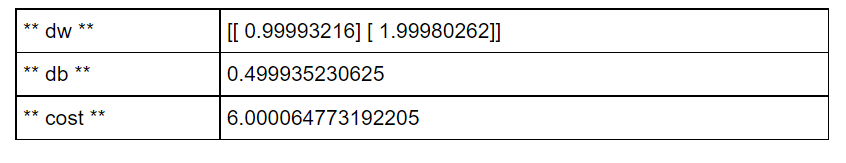

**d) Optimization**
Você inicializou seus parâmetros.
Você também pode calcular uma função de custo e seu gradiente.
Agora, você deseja atualizar os parâmetros usando gradiente descendente.
Exercício: Anote a função de otimização. O objetivo é aprender w e b minimizando a função de custo J. Para um parâmetro θ, a regra de atualização é θ = θ − α dθ, onde α é a taxa de aprendizado.

In [60]:
# GRADED FUNCTION: optimize

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        
        # Cost and gradient calculation (≈ 1-4 lines of code)
        ### START CODE HERE ### 
        grads, cost = propagate(w, b, X, Y)
        ### END CODE HERE ###
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule (≈ 2 lines of code)
        ### START CODE HERE ###
        w = w - learning_rate*dw
        b = b - learning_rate*db
        ### END CODE HERE ###
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training examples
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [61]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.1124579 ]
 [0.23106775]]
b = 1.5593049248448891
dw = [[0.90158428]
 [1.76250842]]
db = 0.4304620716786828


Saída esperada:

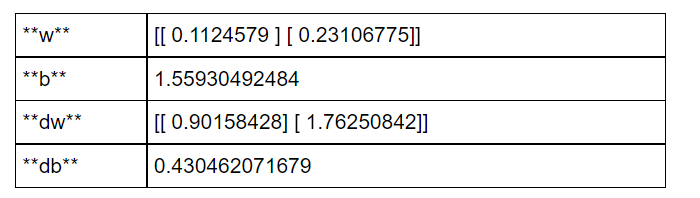

**Exercício: **A função anterior produzirá os w e b aprendidos. Podemos usar w e b para prever os rótulos de um conjunto de dados X. Implementar a função predict(). 

Existem duas etapas para calcular as previsões:

1. Calculate 

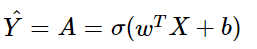

2. Converta as entradas de a em 0 (se ativação <= 0,5) ou 1 (se ativação> 0,5), armazena as previsões em um vetor Y_prediction. Se desejar, você pode usar uma instrução if / else em um loop for (embora também haja uma maneira de vetorizar isso).

In [62]:
# GRADED FUNCTION: predict

def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    ### START CODE HERE ### (≈ 1 line of code)

    A = sigmoid(np.dot(w.T, X) + b)

    ### END CODE HERE ###
    
    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        ### START CODE HERE ### (≈ 4 lines of code)

        if A[0, i] <= 0.5:
            Y_prediction[0, i] = 0
        else:
            Y_prediction[0, i] = 1

        ### END CODE HERE ###
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [63]:
print ("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1.]]


Saída esperada:

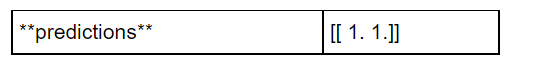

**Importante lembrar:** você implementou várias funções que:

Inicializar (w, b)
Otimize a perda iterativamente para aprender os parâmetros (w, b):
calcular o custo e seu gradiente
atualizando os parâmetros usando gradiente descendente
Use o aprendido (w, b) para prever os rótulos para um determinado conjunto de exemplos

# **5 - Juntar todas as funções em um modelo**
Agora você verá como o modelo geral é estruturado, reunindo todos os blocos de construção (funções implementadas nas partes anteriores), na ordem certa.

Exercício: Implemente a função do modelo. Use a seguinte notação:

- Y_prediction para suas previsões no conjunto de teste
- Y_prediction_train para suas previsões no conjunto de trens
- w, custos, grads para os resultados de optimize()

In [64]:
# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    ### START CODE HERE ###
    
    ### Inicialize os parâmetros com zeros (≈ 1 linha de código) ###
    w, b = initialize_with_zeros(X_train.shape[0])

    ### Gradiente descendente (≈ 1 linha de código) ###
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost=False)
    
    ### Recupere os parâmetros w e b do dicionário 'parameters' ###
    w = parameters["w"]
    b = parameters["b"]
    
    ### Prever os rótulos do conjunto de treinamento e do conjunto de testes (≈ 2 linhas de código) ###
    Y_prediction_train = predict(w, b, X_train)
    Y_prediction_test = predict(w, b, X_test)

    ### END CODE HERE ###

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

Execute a seguinte célula para treinar seu modelo.

In [65]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)


train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


Expected Output:

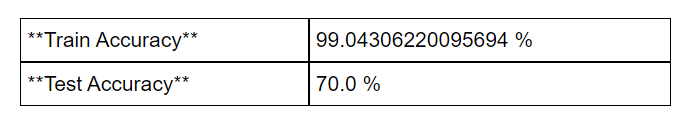

**Comentário:** A precisão do treinamento está próxima de 100%. Esta é uma boa verificação de integridade: seu modelo está funcionando e tem capacidade alta o suficiente para ajustar os dados de treinamento. O erro de teste é de 68%. Na verdade, não é ruim para este modelo simples, dado o pequeno conjunto de dados que usamos e que a regressão logística é um classificador linear. Mas não se preocupe, você construirá um classificador ainda melhor na próxima semana!

Além disso, você vê que o modelo está claramente superando os dados de treinamento. Posteriormente nesta especialização, você aprenderá como reduzir o sobreajuste, por exemplo, usando a regularização. Usando o código abaixo (e alterando a variável de índice), você pode ver as previsões nas imagens do conjunto de teste.

y = 1, you predicted that it is a cat


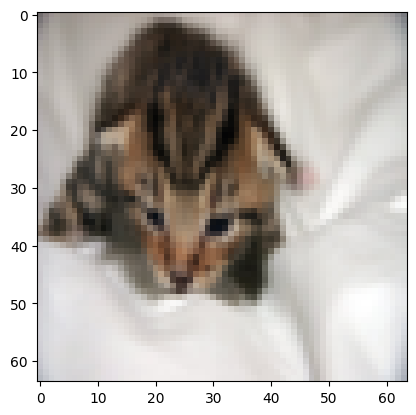

In [66]:
# Example of a picture that was wrongly classified.
index = 1
if d["Y_prediction_test"][0,index] == 1:
   cat = "cat" 
else:
   cat = "not cat"
cat
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a "  + cat) 
#classes[d["Y_prediction_test"][0,index]].decode("utf-8")) +  "\" picture.")


Vamos também representar graficamente a função de custo e os gradientes.

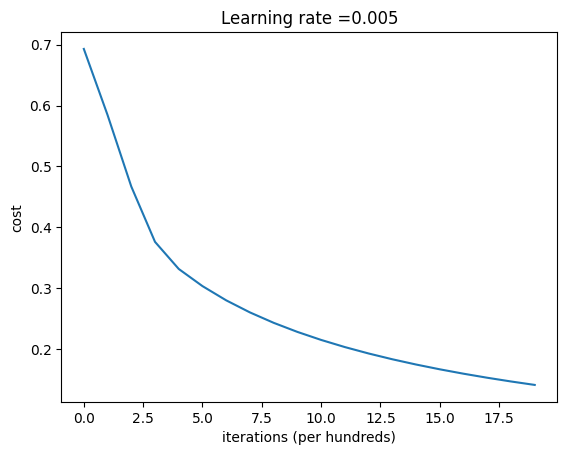

In [67]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

**Interpretação:** Você pode ver a redução do custo. Mostra que os parâmetros estão sendo aprendidos. No entanto, você vê que pode treinar o modelo ainda mais no conjunto de treinamento. Tente aumentar o número de iterações na célula acima e execute novamente as células. Você pode ver que a precisão do conjunto de treinamento aumenta, mas a precisão do conjunto de teste diminui. Isso é chamado de overfitting.




# **6 - Análise adicional (exercício opcional / não classificado)**
Parabéns por construir seu primeiro modelo de classificação de imagem. Vamos analisá-lo mais a fundo e examinar as opções possíveis para a taxa de aprendizagem α.

**Escolha da taxa de aprendizagem**

**Lembrete:** para que o Gradient Descent funcione, você deve escolher a taxa de aprendizagem com sabedoria. A taxa de aprendizagem α determina a rapidez com que atualizamos os parâmetros. Se a taxa de aprendizado for muito grande, podemos "ultrapassar" o valor ideal. Da mesma forma, se for muito pequeno, precisaremos de muitas iterações para convergir para os melhores valores. É por isso que é fundamental usar uma taxa de aprendizado bem ajustada.

Vamos comparar a curva de aprendizado de nosso modelo com várias opções de taxas de aprendizado. Execute a célula abaixo. Isso deve levar cerca de 1 minuto. Sinta-se à vontade também para tentar valores diferentes dos três que inicializamos na variável learning_rates para conter e ver o que acontece.

learning rate is: 0.01
train accuracy: 99.52153110047847 %
test accuracy: 68.0 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 88.99521531100478 %
test accuracy: 64.0 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 68.42105263157895 %
test accuracy: 36.0 %

-------------------------------------------------------



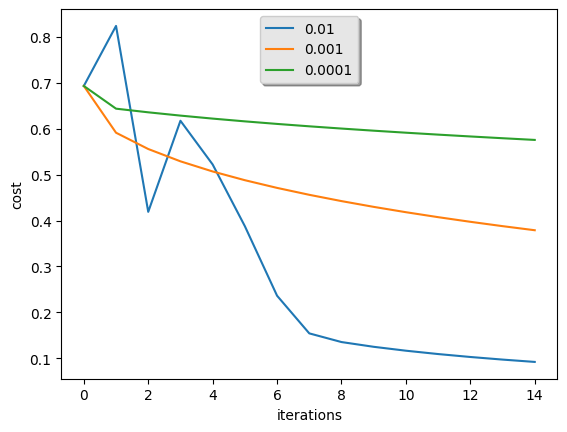

In [68]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

**Interpretação:**

Taxas de aprendizagem diferentes fornecem custos diferentes e, portanto, resultados de previsões diferentes.
Se a taxa de aprendizado for muito grande (0,01), o custo pode oscilar para cima e para baixo. Pode até divergir (embora, neste exemplo, usar 0,01 ainda termine eventualmente com um bom valor para o custo).
Um custo menor não significa um modelo melhor. Você deve verificar se há possibilidade de sobreajuste. Acontece quando a precisão do treinamento é muito maior do que a precisão do teste.

No aprendizado profundo, geralmente recomendamos que você:
Escolha a taxa de aprendizagem que minimiza melhor a função de custo.
Se o seu modelo superajustar, use outras técnicas para reduzir o superajuste. 

O que lembrar desta tarefa:

O pré-processamento do conjunto de dados é importante.
Você implementou cada função separadamente: initialize(), propagate(), optimize().. Então você construiu um model().
Ajustar a taxa de aprendizado (que é um exemplo de "hiperparâmetro") pode fazer uma grande diferença para o algoritmo. Você verá mais exemplos disso posteriormente neste curso!
Finalmente, se desejar, o convidamos a experimentar coisas diferentes neste Notebook. Certifique-se de enviar antes de tentar qualquer coisa. Depois de enviar, as coisas com as quais você pode brincar incluem:

- Brinque com a taxa de aprendizado e o número de iterações
- Experimente diferentes métodos de inicialização e compare os resultados
- Teste outros pré-processamento (centralize os dados ou divida cada linha por seu desvio padrão)

Bibliografia

http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/
https://stats.stackexchange.com/questions/211436/why-do-we-normalize-images-by-subtracting-the-datasets-image-mean-and-not-the-c